<h1>FIFA 23 ML Project  <img src="https://img.icons8.com/color/48/null/football-team.png"/></h1>

Avec l’augmentation de la qualité et de la quantité des statistiques disponibles, le football est de plus en plus axé sur les données. Il est intéressant de noter qu’au moins en Premier League, la révolution des données n’a pas le plus grand impact en haut du classement. Alors que le top 6 est resté relativement stable, des clubs comme Brentford et Brighton ont pu exploiter les données pour frapper bien au-dessus de leur poids, Brentford obtenant des finitions confortables au milieu du tableau et Brighton se qualifiant pour la compétition européenne pour la première fois de son histoire.

Dans cette optique, le public s’intéresse de plus en plus à la manière dont les équipes exploitent les données, et plus de clubs que jamais emploient des directeurs de football pour superviser le recrutement. Bien que l’exactitude de la base de données de la FIFA puisse être discutable, elle constitue une abstraction utile des attributs des joueurs, et j’aimerais l’utiliser dans ce cas pour déterminer ce qui pourrait intéresser un directeur de football.

#Introducing the Team!

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Pour cette analyse, je vais me pencher sur le FC Séville en Liga espagnole. Membre fondateur de la ligue, Séville est l'une des équipes les plus décorées de l'histoire de la ligue, avec 6 coupes d'Europe, 6 coupes de l'UEFA, 4 coupes d'Espagne, 6 supercoupes d'Espagne, 1 coupe du monde des clubs de la FIFA et 3 supercoupes de l'UEFA à son actif. Cependant, le dernier trophée remporté par l'équipe remonte à 2022, lorsqu'elle a remporté la Ligue Europa.

L'objectif de cette analyse est de recommander des joueurs à acheter (et à vendre) afin que l'équipe puisse à nouveau rivaliser au plus haut niveau de la ligue et remporter des trophées. Pour commencer l'analyse, je vais examiner la façon dont l'équipe est configurée pour jouer afin de mieux comprendre le type de football que le personnel technique et le conseil d'administration souhaitent que l'équipe joue

In [ ]:
!pip install lazypredict

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, train_test_split
import os

In [ ]:
teams_df = pd.read_csv('/gdrive/MyDrive/FIFA-23-ML-Project/male_teams.csv', low_memory=False)

In [ ]:
teams_df.head()

,team_id,team_url,fifa_version,fifa_update,fifa_update_date,team_name,league_id,league_name,league_level,nationality_id,...,off_corners,off_free_kicks,build_up_play_speed,build_up_play_dribbling,build_up_play_passing,build_up_play_positioning,chance_creation_passing,chance_creation_crossing,chance_creation_shooting,chance_creation_positioning
0,10,/team/10/manchester-city/230009,23,9,2023-01-13,Manchester City,13,Premier League,1.00,14,...,3.00,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,73,/team/73/paris-saint-germain/230009,23,9,2023-01-13,Paris Saint Germain,16,Ligue 1,1.00,18,...,3.00,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,243,/team/243/real-madrid/230009,23,9,2023-01-13,Real Madrid,53,La Liga,1.00,45,...,3.00,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1337,/team/1337/germany/230009,23,9,2023-01-13,Germany,78,Friendly International,NaN,21,...,3.00,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,/team/5/chelsea/230009,23,9,2023-01-13,Chelsea,13,Premier League,1.00,14,...,3.00,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


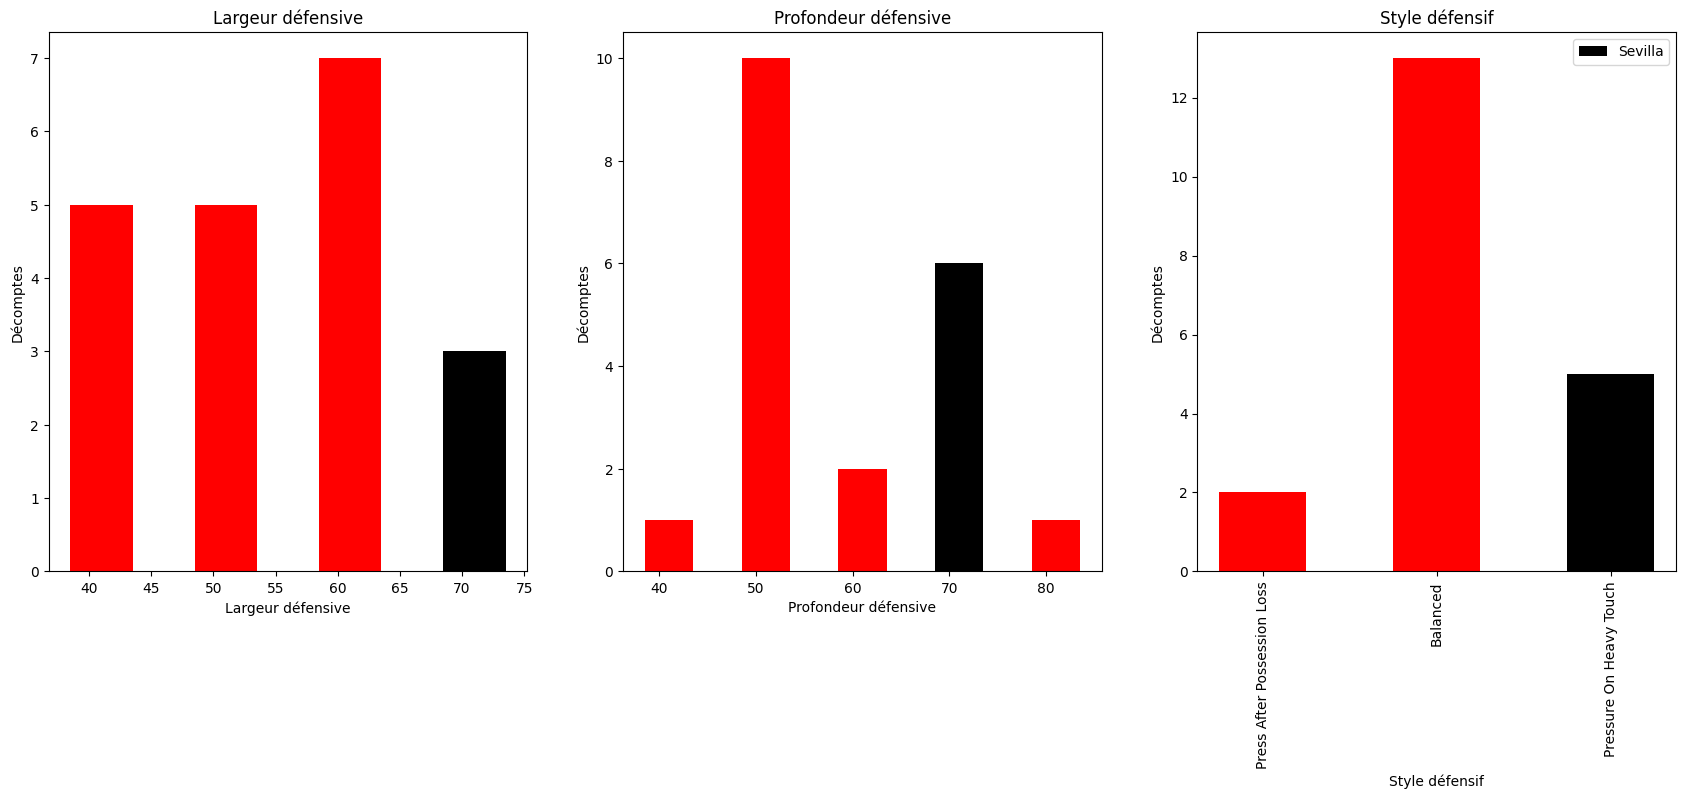

In [ ]:
# Définir nos fonctions
def createBarPlot(ax, label, width):
    '''Trace le graphique des données pour les clubs de La Liga, en mettant en évidence  Seville pour la caractéristique spécifiée'''
    label_data = list(set(Liga_df[label]))
    label_data_counts = [list(Liga_df[label]).count(i) for i in label_data]
    ax.bar(label_data, label_data_counts, width=width, color='red')
    ax.set_title(label)
    ax.set_xlabel(label)
    ax.set_ylabel('Décomptes')
    Sevilla_data = Liga_df[Liga_df['Nom de léquipe'] == 'Sevilla'][label].iloc[0]
    ax.bar(Sevilla_data, label_data_counts[label_data.index(Sevilla_data)], label='Sevilla',
           color='black', width=width)

def evaluateModels(df, xcols, ycol):
    '''Exécute l'ensemble de données à travers un LazyRegressor pour évaluer les performances du modèle'''
    X = test_df[xcols]
    y = test_df[ycol]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    return models, predictions

def createAverage(df, cols, alias):
    df[alias] = df[cols].mean(axis=1)
    return df

# Importer et nettoyer les données
lazypredict.Supervised.REGRESSORS = lazypredict.Supervised.REGRESSORS[:30]
teams_df = pd.read_csv('/gdrive/MyDrive/FIFA-23-ML-Project/male_teams.csv', low_memory=False)

boolFilter = (teams_df['league_name'] == 'La Liga') &\
             (teams_df['fifa_version'] == 23) &\
             (teams_df['fifa_update'] == 9)

relevantCols = ['team_name',
                'def_team_width',
                'def_team_depth',
                'def_style',
                'off_build_up_play',
                'off_chance_creation',
                'off_team_width']

cleanNames = ['Nom de léquipe',
              'Largeur défensive',
              'Profondeur défensive',
              'Style défensif',
              'Méthode de construction du jeu',
              'Méthode de création doccasions',
              'Largeur offensive']

Liga_df = pd.DataFrame(teams_df[boolFilter][relevantCols])
Liga_df.columns = cleanNames
fig, ax = plt.subplots(1, 3)
fig.set_figheight(7)
fig.set_figwidth(21)
del(teams_df)

# Tracer les largeurs défensives
createBarPlot(ax[0], 'Largeur défensive', 5)
createBarPlot(ax[1], 'Profondeur défensive', 5)
createBarPlot(ax[2], 'Style défensif', 0.5)

plt.xticks(rotation=90)
plt.legend()
plt.show()

1. **Graphique de la Largeur Défensive (Defensive Width) :**
   - Ce graphique présente la distribution de la largeur défensive pour toutes les équipes de La Liga (en rouge).
   - Une barre noire est ajoutée pour représenter la valeur de la largeur défensive spécifique au FC Barcelona. Cette barre est mise en évidence par rapport aux autres équipes.

2. **Graphique de la Profondeur Défensive (Defensive Depth) :**
   - De manière similaire, ce graphique illustre la distribution de la profondeur défensive pour l'ensemble des équipes de La Liga.
   - Une barre noire représente la profondeur défensive spécifique au FC Barcelona, mise en évidence par rapport aux autres équipes.

3. **Graphique du Style Défensif (Defensive Style) :**
   - Ce graphique affiche la distribution du style défensif pour l'ensemble des équipes de La Liga.
   - Une barre noire est ajoutée pour indiquer la valeur du style défensif spécifique au FC Barcelona, mettant en évidence sa position par rapport aux autres équipes.

*Légende :*
- Les barres rouges représentent la distribution des valeurs pour toutes les équipes de La Liga.
- La barre noire représente la valeur spécifique au FC Barcelona, mise en évidence dans chaque graphique.

Ces graphiques permettent de comparer visuellement les caractéristiques défensives du FC Barcelona par rapport aux autres équipes de La Liga, pour les aspects de largeur, profondeur et style défensif.

# Voyons maintenant comment FC Séville est actuellement configuré pour defendre :

Les graphiques ci-dessus illustrent la formation défensive de base de chaque équipe de la Liga. La largeur défensive indique l'espacement des joueurs lorsque l'équipe n'a pas le ballon, une valeur plus élevée correspondant à un écart plus important entre les joueurs. La profondeur défensive indique à quelle hauteur du terrain les joueurs affrontent l'adversaire, un nombre plus bas correspondant à une équipe qui défend plus près de son propre but.

Les lignes verticales vertes correspondent à la position du FC Séville sur la répartition. Comme on peut le voir, la largeur défensive du FC Séville est légèrement inférieure à la moyenne de la Liga, mais ils défendent légèrement plus haut sur le terrain que la moyenne. On peut également voir que l'équipe est positionnée pour presser l'adversaire en cas de mauvaise touche, c'est-à-dire lorsque le joueur adverse manque un contrôle de passe ou joue le ballon vers son propre but. Ces deux situations présentent un risque élevé de perte de balle et offrent à l'équipe l'occasion de récupérer le ballon plus haut sur le terrain. Ce style explique la profondeur défensive relativement élevée du FC Séville, car il permet à l'équipe de défendre en conservant sa formation, tout en pouvant rapidement passer au pressing si l'opportunité se présente.

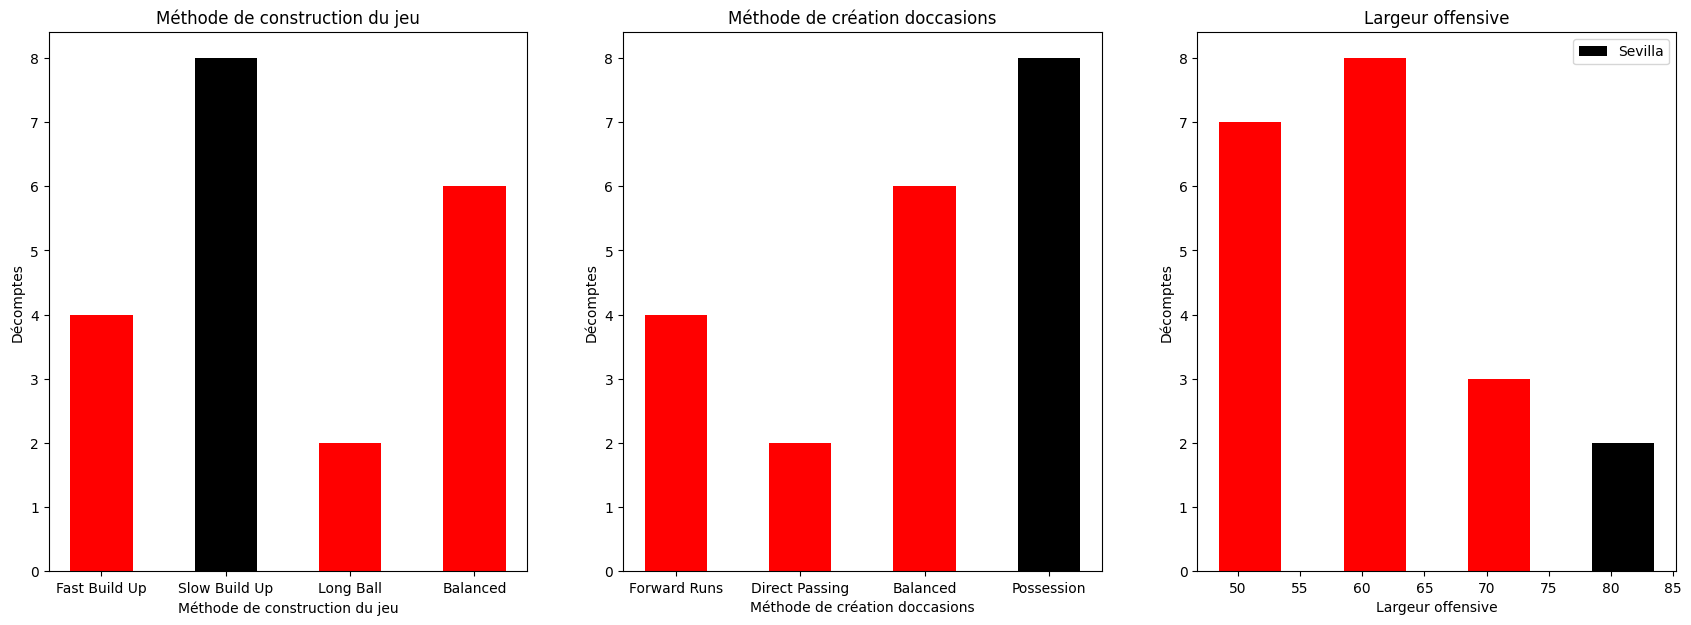

In [ ]:
fig, ax = plt.subplots(1, 3)
fig.set_figheight(7)
fig.set_figwidth(21)

createBarPlot(ax[0], 'Méthode de construction du jeu', 0.5)
createBarPlot(ax[1], 'Méthode de création doccasions', 0.5)
createBarPlot(ax[2], 'Largeur offensive', 5)

plt.legend()
plt.show()

Modèles de formation pour prédire les attributs des joueurs
Maintenant que nous en savons un peu plus sur l'équipe et sur la façon dont elle aimerait jouer, nous pouvons commencer à examiner des modèles d'entraînement sur les attributs des joueurs pour prédire quels joueurs seraient les mieux placés pour recruter. Compte tenu des attentes du conseil d'administration, il n'y a pas de pression immédiate pour réussir immédiatement, nous pouvons donc nous permettre de recruter des joueurs avec des notes globales inférieures maintenant, dans l'espoir qu'ils grandissent dans le système. Je pense qu'un joueur dans les futures versions de FIFA est déterminé en grande partie par 3 facteurs principaux :

Capacité globale - Une moyenne pondérée des attributs basée sur la position d'un joueur conçue pour donner une idée de la qualité du joueur, classée de 1 à 99. Un joueur avec une capacité globale élevée est susceptible de continuer à avoir une capacité élevée dans un avenir proche.
Âge - L'âge du joueur. Un joueur plus jeune est plus susceptible de grandir et de grandir plus vite qu’un joueur à son apogée.
Potentiel - Un score attribué à chaque joueur par EA déterminant ce qu'il pense que le joueur ayant évalué ses capacités peut réaliser à son apogée. En supposant que la note soit raisonnable, un joueur est susceptible d'atteindre son potentiel. J'aimerais que l'équipe atteigne son « apogée » dans environ 4 ans, car cela nous donne un équilibre raisonnable entre obtenir des résultats le plus rapidement possible et consacrer du temps pour les atteindre. . Pour évaluer où se situera l'ensemble d'un joueur dans 4 ans, j'utiliserai les données de FIFA 19 et comparerai les joueurs de FIFA 19 et 23 pour prévoir comment les joueurs sont susceptibles de se développer dans 4 ans. La première approche tentera simplement de prédire les capacités globales du joueur :

# Voyons maintenant comment FC Séville est actuellement configuré pour attaquer :

Les graphiques ci-dessus présentent différentes façons d'analyser le jeu offensif de chaque équipe de la Liga. La "méthode de construction" décrit comment l'équipe sort le ballon de son propre camp. Le FC Séville choisit de jouer de facon "slow build up", une méthode de possession de balle lente et contrôlée. L'équipe utilise un jeu de passes courtes et précises pour progresser vers l'avant, en essayant de créer des décalages et des opportunités de tir.


La méthode de création d'occasions décrit la façon dont l'équipe joue une fois le ballon dans le camp adverse. Avec la possession du ballon, les joueurs effectuent des mouvements et des passes courts et précis pour créer des opportunités de but. Les ballons sont joués dans les espaces entre les lignes adverses, plutôt que joués vers l'avant en profondeur. La largeur offensive de l'équipe est également assez forte par rapport au reste du championnat.

Il est également important de noter la formation de l'équipe, la formation préférée étant actuellement le 4-3-3. Dans ce système, quatre défenseurs assurent la solidité défensive, tandis que trois milieux de terrain offrent des options de transition offensive et de création de jeu. Les trois attaquants de devant sont chargés de la finition et de l'exploitation des espaces créés par leurs coéquipiers.

En réunissant ces informations, nous pouvons commencer à former une image du style de jeu souhaité par le FC Séville. Cela nous permettra également d'établir un profil du joueur que nous souhaitons recruter :

Avec ou sans ballon, le FC Séville adopte un positionnement plutôt large. Nos joueurs devront donc être capables de contrôler et de circuler le ballon dans des zones où l'espace est important.

L'équipe se crée des occasions en jouant la possession du ballon et en utilisant des passes courtes et précises pour créer des décalages. Les attaquants devront être techniques, dotés d'une bonne vision du jeu et capables de se créer des occasions en un contre un.

L'équipe a pour volonté de ne pas jouer dans sa propre moitié de terrain. Les défenseurs devront donc être capables de jouer le ballon long avec précision et d'offrir des options de relance.

En tenant compte de ces éléments, voici un profil type du joueur recherché par le FC Séville :

Joueur technique et à l'aise dans les grands espaces.
Bon passeur et capable de créer des occasions pour ses coéquipiers.
Rapide et doté d'une bonne endurance pour participer aux contres et à la possession du ballon.
Bon jeu de tête pour les ballons longs et les situations de jeu aérien.
Défenseur précis dans ses passes longues et bon relanceur.
En recrutant des joueurs correspondant à ce profil, le FC Séville pourra mettre en place son style de jeu et atteindre ses objectifs.

#Entraîner des modèles pour prédire les attributs des joueurs


Maintenant que nous en savons un peu plus sur l'équipe et sa philosophie de jeu, nous pouvons commencer à explorer des modèles d'entraînement basés sur les attributs des joueurs afin de prédire ceux qui seraient les meilleurs à recruter. Compte tenu des attentes du conseil d'administration, il n'y a pas de pression immédiate pour réussir instantanément. Nous pouvons donc nous permettre de signer des joueurs ayant des évaluations globales plus faibles maintenant, en espérant qu'ils s'intégreront au système et progresseront. Je pense que la note globale d'un joueur dans les futures versions de FIFA est largement déterminée par 3 facteurs principaux :

Note globale : une moyenne pondérée des attributs en fonction du poste du joueur, conçue pour donner une idée de sa qualité, allant de 1 à 99. Un joueur ayant une note globale élevée aura probablement une bonne note globale dans un avenir proche.
Âge : l'âge du joueur. Un joueur plus jeune est plus susceptible de se développer et de progresser plus rapidement qu'un joueur à son apogée.
Potentiel : une note attribuée à chaque joueur par EA Sports, déterminant ce qu'ils pensent que le joueur peut atteindre comme note globale à son apogée. En supposant que la note est raisonnable, un joueur est susceptible de se rapprocher de son potentiel.
J'aimerais que l'équipe atteigne son apogée dans environ 4 ans, car cela nous donne un équilibre raisonnable entre l'obtention de résultats le plus rapidement possible et le temps consacré à les atteindre. Pour évaluer la note globale d'un joueur dans 4 ans, j'utiliserai les données de FIFA 19 et comparerai les joueurs présents dans les deux versions (FIFA 19 et 23) afin de prévoir leur évolution probable dans les 4 prochaines années. La première approche consistera simplement à essayer de prédire la note globale du joueur.

In [ ]:
# Charger les données des joueurs FIFA 19 et FIFA 23 à partir des fichiers CSV
all_players_df19 = pd.read_csv('/gdrive/MyDrive/FIFA-23-ML-Project/male_players_19version4.csv', engine='python')
all_players_df23 = pd.read_csv('/gdrive/MyDrive/FIFA-23-ML-Project/male_players_23version4.csv', engine='python')

# Filtrer les données pour ne conserver que les joueurs de FIFA 19 et FIFA 23 respectivement
df_19 = all_players_df19[all_players_df19['fifa_version'] == 19]
df_23 = all_players_df23[all_players_df23['fifa_version'] == 23]

# Fusionner les DataFrames sur la colonne 'player_id' en utilisant une jointure interne
test_df = pd.merge(df_19, df_23[['player_id', 'overall']], how='inner', suffixes=['_19', '_23'], on='player_id')

# Sélectionner les colonnes pertinentes pour l'entraînement du modèle
xcols = ['overall_19', 'age', 'potential']
ycol = 'overall_23'

# Évaluer les modèles en utilisant une fonction personnalisée 'evaluateModels'
models, predictions = evaluateModels(test_df, xcols, ycol)

# Renvoyer les modèles évalués
models

100%|██████████| 30/30 [01:20<00:00,  2.67s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.60,0.60,3.67,0.44
NuSVR,0.60,0.60,3.67,5.18
MLPRegressor,0.60,0.60,3.67,6.40
HistGradientBoostingRegressor,0.59,0.59,3.69,0.16
ElasticNetCV,0.59,0.59,3.70,0.27
LassoCV,0.59,0.59,3.70,0.17
BayesianRidge,0.59,0.59,3.70,0.03
LinearRegression,0.59,0.59,3.70,0.02
OrthogonalMatchingPursuitCV,0.59,0.59,3.70,0.02


Après avoir entraîné le modèle initial, nous obtenons un résultat quelque peu inattendu. Les caractéristiques que nous avons présentées comme étant importantes pour déterminer la progression d'un joueur ne semblent pas être une bonne mesure de tout, nos modèles n'expliquant qu'environ 58% de la variance observée dans la caractéristique prédite. Cela peut s'expliquer par plusieurs raisons. La croissance des joueurs peut être non linéaire, ce qui signifie que le modèle linéaire que nous avons choisi ne peut pas facilement prendre en compte les progressions irrégulières. De plus, nous avons supposé que la caractéristique "potentiel" est une mesure précise de la capacité ultime d'un joueur, ce qui n'est peut-être pas le cas

In [ ]:
# Sélectionner les colonnes pertinentes pour le DataFrame de démonstration
demo_df = test_df[['short_name', 'overall_19', 'age', 'potential', 'overall_23']]

# Filtrer les joueurs qui ont régressé (overall_19 > overall_23 et overall_19 < potential)
regressed_players = demo_df[(demo_df['overall_19'] > demo_df['overall_23']) & (demo_df['overall_19'] < demo_df['potential'])]

# Calculer le pourcentage de joueurs ayant régressé par rapport à l'ensemble de test
testCount = test_df.shape[0]
demoCount_regressed = regressed_players.shape[0]
print('{}% des joueurs ont régressé'.format(round((demoCount_regressed / testCount) * 100, 2)))

# Filtrer les joueurs qui ont dépassé leur potentiel (potential < overall_23 et overall_19 < potential)
exceeded_potential_players = demo_df[(demo_df['potential'] < demo_df['overall_23']) & (demo_df['overall_19'] < demo_df['potential'])]

# Calculer le pourcentage de joueurs ayant dépassé leur potentiel par rapport à l'ensemble de test
demoCount_exceeded = exceeded_potential_players.shape[0]
print('{}% des joueurs ont dépassé leur potentiel'.format(round((demoCount_exceeded / testCount) * 100, 2)))

22.38% des joueurs ont régressé
7.38% des joueurs ont dépassé leur potentiel


De ce qui précède, nous pouvons voir que même si tous les joueurs de notre échantillon avaient une note potentielle supérieure à leurs capacités actuelles, 17,5 % des joueurs ont obtenu des scores globaux pires dans FIFA 23 que dans FIFA 19. De plus, un pourcentage tout aussi élevé des joueurs dépassent leur potentiel attendu. Cela pose certainement un problème pour notre analyse ; Si nous ne pouvons pas vraiment prédire la qualité future d'un joueur sur cette fonctionnalité potentielle, il sera très difficile de recommander des joueurs à l'achat.

Défenseurs de reconnaissance
Étant donné que la fonctionnalité globale est volatile et difficile à prédire en raison de la myriade de facteurs qui régissent le développement des joueurs, il peut être plus facile de prédire le développement des joueurs sur une base attribut par attribut. Puisque nous avons établi un profil des joueurs que nous aimerions recruter, nous pouvons prendre ces attributs seuls et faire des pronostics sur eux seuls. Puisque nous avons expliqué que nous aimerions que nos défenseurs jouent des passes longues précises, commençons par prédire comment l'attribut de passe longue évolue au fil du temps :

In [ ]:
# Colonnes spécifiques pour les attributs des défenseurs
cols = ['skill_long_passing', 'skill_ball_control', 'passing']

# Alias pour représenter les attributs des défenseurs
alias = 'defender_attributes'

# Créer la moyenne des attributs des défenseurs pour FIFA 19
def_19 = createAverage(df_19, cols, alias)

# Créer la moyenne des attributs des défenseurs pour FIFA 23
def_23 = createAverage(df_23, cols, alias)

# Fusionner les DataFrames sur la colonne 'player_id' en utilisant une jointure interne
test_df = pd.merge(df_19, df_23[['player_id', 'defender_attributes']], how='inner', suffixes=['_19', '_23'], on='player_id')

# Colonnes à utiliser comme caractéristiques pour l'entraînement du modèle
xcols = ['defender_attributes_19', 'age', 'potential']
ycol = 'defender_attributes_23'

# Évaluer les modèles en utilisant une fonction personnalisée 'evaluateModels'
models, predictions = evaluateModels(test_df, xcols, ycol)

# Renvoyer les modèles évalués
models

100%|██████████| 30/30 [01:21<00:00,  2.72s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.76,0.76,4.21,0.53
MLPRegressor,0.76,0.76,4.24,5.59
HistGradientBoostingRegressor,0.76,0.76,4.24,0.17
NuSVR,0.75,0.75,4.28,5.39
Lars,0.74,0.74,4.36,0.02
LinearRegression,0.74,0.74,4.36,0.01
OrthogonalMatchingPursuitCV,0.74,0.74,4.36,0.02
LassoLarsIC,0.74,0.74,4.36,0.01
LassoLarsCV,0.74,0.74,4.36,0.04


<img src="https://gamesmix.net/wp-content/uploads/2022/03/FIFA-23.jpeg" width="900"/>

In [ ]:
from sklearn.linear_model import LassoCV

predict_df = df_23[['defender_attributes', 'age', 'potential']]
predict_df.columns = ['defender_attributes_19', 'age', 'potential']

model = LassoCV()
model.fit(test_df[xcols], test_df[ycol])
df_23['defender_attributes_prediction'] = model.predict(predict_df)
def_df = df_23[['short_name',
                'overall',
                'value_eur',
                'wage_eur',
                'age',
                'nationality_name',
                'club_name',
                'player_positions',
                'defender_attributes',
                'defender_attributes_prediction']].sort_values(by = ['defender_attributes_prediction'],
                 ascending = False)
Sev_df = def_df[['CB' in def_df['player_positions'].iloc[i] for i in range(def_df['player_positions'].shape[0])]]
Sev_df = Sev_df[Sev_df['club_name'] == 'Sevilla']
Sev_df.head()

,short_name,overall,value_eur,wage_eur,age,nationality_name,club_name,player_positions,defender_attributes,defender_attributes_prediction
12402,N. Gudelj,79,14500000.00,29000.00,30,Serbia,Sevilla,"['CDM', 'CB']",78.33,74.27
5553,Fernando,83,12500000.00,39000.00,34,Brazil,Sevilla,"['CDM', 'CB']",76.67,71.99
12072,Marcão,79,21500000.00,29000.00,26,Brazil,Sevilla,['CB'],68.67,69.30
16013,T. Nianzou,73,6000000.00,13000.00,20,France,Sevilla,['CB'],63.33,67.87
9110,K. Rekik,77,11000000.00,25000.00,27,Netherlands,Sevilla,"['CB', 'LB']",65.67,66.31


In [ ]:
def_df = def_df[['CB' in def_df['player_positions'].iloc[i] for i in range(def_df['player_positions'].shape[0])]]
def_df = def_df[(def_df['value_eur'] < 30000000) & (def_df['wage_eur'] < 150000)]
def_df = def_df[def_df['age'] < 25]
def_df.head()

,short_name,overall,value_eur,wage_eur,age,nationality_name,club_name,player_positions,defender_attributes,defender_attributes_prediction
5087,F. Dimarco,79,24500000.00,51000.00,24,Italy,Inter,"['LWB', 'LM', 'CB']",78.67,77.35
12839,O. Boscagli,77,14500000.00,15000.00,24,France,PSV,"['CB', 'LB', 'CDM']",76.67,75.69
4665,E. Ndicka,80,29500000.00,28000.00,22,France,Eintracht Frankfurt,['CB'],75.00,75.60
4904,Eric García,76,14000000.00,67000.00,21,Spain,FC Barcelona,['CB'],74.00,75.03
2811,C. Lukeba,76,15000000.00,25000.00,19,France,Olympique Lyonnais,['CB'],71.00,73.98


In [ ]:

# Colonnes spécifiques pour les attributs des défenseurs
cols = ['skill_dribbling', 'mentality_vision','passing']

# Alias pour représenter les attributs des défenseurs
alias = 'wide_attributes'

# Créer la moyenne des attributs des défenseurs pour FIFA 19
def_19 = createAverage(df_19, cols, alias)

# Créer la moyenne des attributs des défenseurs pour FIFA 23
def_23 = createAverage(df_23, cols, alias)

# Fusionner les DataFrames sur la colonne 'player_id' en utilisant une jointure interne
test_df = pd.merge(df_19, df_23[['player_id', 'wide_attributes']], how='inner', suffixes=['_19', '_23'], on='player_id')

# Colonnes à utiliser comme caractéristiques pour l'entraînement du modèle
xcols = ['wide_attributes_19', 'age', 'potential']
ycol = 'wide_attributes_23'

# Évaluer les modèles en utilisant une fonction personnalisée 'evaluateModels'
models, predictions = evaluateModels(test_df, xcols, ycol)

# Renvoyer les modèles évalués
models

100%|██████████| 30/30 [01:23<00:00,  2.79s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.81,0.81,4.31,0.56
HistGradientBoostingRegressor,0.81,0.81,4.32,0.20
MLPRegressor,0.81,0.81,4.35,5.42
NuSVR,0.81,0.81,4.36,4.76
ElasticNetCV,0.80,0.80,4.46,0.16
LassoCV,0.80,0.80,4.46,0.25
BayesianRidge,0.80,0.80,4.47,0.01
LassoLarsIC,0.80,0.80,4.47,0.02
LarsCV,0.80,0.80,4.47,0.06
